Aim to complete as much of this tutorial on your own *before* coming to the practical session.

Use the practical session to get help for any aspect you do not understand or were unable to complete.

# Classification and Regression 3

Learning objectives
1. Apply RFs and GBDTs in a multi-group classification setting using the popular python libraries [sklearn](https://scikit-learn.org/stable/) and [xgboost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)
2. Explore differences in model performance based on changing model parameters
3. Visualise the important variables 
4. Apply RFs and GBDTs in a regression setting and explore the results

## Ensure you have installed xgboost _before_ starting the notebook

xgboost is implemented in the `xgboost` package.

Install it via ```conda install -c conda-forge xgboost``` or ```pip install xgboost``` in the terminal.

## Import specific packages and functions

In [1]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.manifold import MDS 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, classification_report
import xgboost as xgb
import sklearn

## Load in dataset

We will follow the steps from the Classification and Regression 2 (BIDS 8) tutorial for loading, scaling, and splitting the data in preparation for using these as input to the models. Here we use the cancer microbiome dataset.

In [2]:
cancer_microbiome_genus = pd.read_excel('../Data-main/cancer_microbiome_genus.xlsx')
cancer_microbiome_genus.cancer.value_counts()
cancer_microbiome_genus.adenomas_or_cancer.value_counts()

3    48
0    47
1    26
2    13
Name: adenomas_or_cancer, dtype: int64

In [3]:
# enter your CID here, or date of birth, or another number of your choosing to use as random state
CID = 0

# remember to check the documentation of each algorithm if setting the random_state is needed
# for this tutorial and all upcoming tutorials...

We will use [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) functions [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) as before to split and scale the data.

In [4]:
# Split the data into train and test sets
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(cancer_microbiome_genus.iloc[:, 4:], cancer_microbiome_genus.adenomas_or_cancer, test_size=0.3, random_state=CID)

# Scale the data with standard scaling (0 mean and unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)


## Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the `max_samples` parameter if `bootstrap=True` (default), otherwise the whole dataset is used to build each tree. Some other parameters, specific to Random Forests, that you can set to optimise the [RandomForestClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) are:
- `n_estimators`: the number of trees in the forest
- `criterion`: the function to measure the quality of the split, can be Gini inpurity, log_loss and entropy for the Shannon information gain, look at the specific formulas [here](https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation)
- `max_depth`: the maximum depth of the tree, ie how many nodes to be expanded until all leaves are pure or contain less that `min_samples_split`
- `min_samples_split`: the minimum number of samples required to split an internal node
- `min_samples_leaf`: the minimum number of samples required to be a leaf (terminal) node
- `oob_score`: whether to use out-of-bag samples to estimate the generalization score

Make sure to look at the [RandomForestClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) object page for the rest of the parameters available. You can read more about Random Forests in the user guide [documentation](https://scikit-learn.org/stable/modules/ensemble.html#forest).

Here, we will use the [classification_report()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function to generate a summary of different metrics we used before in BIDS 8.

In [5]:
# define the classifier with default parameters

rf_default = RandomForestClassifier(random_state=CID)
y_pred_default = rf_default.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred_default))
print('accuracy:', accuracy_score(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.43      0.83      0.57        12
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         4
           3       0.71      0.75      0.73        16

    accuracy                           0.54        41
   macro avg       0.29      0.40      0.32        41
weighted avg       0.40      0.54      0.45        41

accuracy: 0.5365853658536586


C:\Users\jmp111\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmp111\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmp111\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3    16
0    12
1     9
2     4
Name: adenomas_or_cancer, dtype: int64

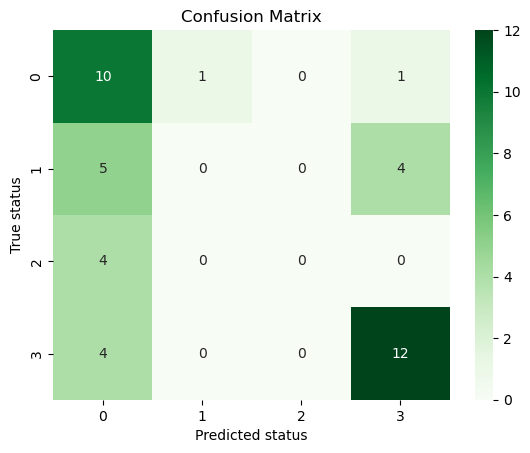

In [6]:
cm_default = confusion_matrix(y_test, y_pred_default)

def conf_matrix_heatmap(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Greens'); #annot=True to annotate cells
    ax.set_xlabel('Predicted status')
    ax.set_ylabel('True status')
    ax.set_title('Confusion Matrix')

conf_matrix_heatmap(cm_default)
display(y_test.value_counts()) # to see the class breakdown in the test-set 

Given what you see at the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) results on true and predicted status for each of the 4 classes, can you explain the zero division warning error we get when trying to calculate the [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) and [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) above?

Now let's change the model parameters and see if we get a higher accuracy score...

In [7]:
rf = RandomForestClassifier(
    n_estimators=1000, 
    criterion='entropy', 
    oob_score=True, 
    class_weight='balanced',
    random_state=CID
)
y_pred = rf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))
print('accuracy:', accuracy_score(y_test, y_pred)) # if you want to look at extra decimals
print('oob score:', rf.oob_score_)

              precision    recall  f1-score   support

           0       0.42      0.92      0.58        12
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         4
           3       0.67      0.62      0.65        16

    accuracy                           0.51        41
   macro avg       0.27      0.39      0.31        41
weighted avg       0.38      0.51      0.42        41

accuracy: 0.5121951219512195
oob score: 0.4838709677419355


C:\Users\jmp111\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmp111\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmp111\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Some questions to consider: 
- Why did we use a balanced class weight?
- What does the oob (out-of-bag) score tell us about the training set?
- Are more estimators (number of trees) always a good idea or is there a threshold?

Have a go at tweaking the different parameters yourself!

### Feature Importance

Feature importances are provided by the fitted attribute `feature_importances_` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree. Impurity-based feature importances can be misleading for high cardinality features (many unique values). For this reason we can use [permutation importance()](https://scikit-learn.org/stable/modules/permutation_importance.html).

We will use the same cancer dataset but change our Y target to the cancer column (0 - no cancer, 1 - cancer).

In [8]:
# Split the data into train and test sets
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(cancer_microbiome_genus.iloc[:, 4:], cancer_microbiome_genus.cancer, test_size=0.3, random_state=CID)

# scale 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

# double check that the y is correct (since we are using same name variables)
display(y_train.value_counts())

0    61
1    32
Name: cancer, dtype: int64

In [9]:
# fit a new model 
rf = RandomForestClassifier(
    n_estimators=100, 
    criterion='gini', 
    oob_score=True,
    random_state=CID
)
y_pred = rf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))
print('oob score:', rf.oob_score_)

              precision    recall  f1-score   support

           0       0.80      0.96      0.87        25
           1       0.91      0.62      0.74        16

    accuracy                           0.83        41
   macro avg       0.85      0.79      0.81        41
weighted avg       0.84      0.83      0.82        41

oob score: 0.7741935483870968


Below we will create a function that looks at the samples on the terminal nodes (leafs) and creates a proximity matrix. This matrix holds information on which samples have ended up together in the same leaf, for example when a pair of samples reach the same leaf in a tree their proximity value increases by one. We then normalise by dividing by the number of trees. We can then use multidimensional scaling, [MDS()](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html) to visualise the sample separation.

In [10]:
def proximity_matrix(rf, X, normalise=True):      
    leafs = rf.apply(X)
    n_trees = leafs.shape[1]
    val = leafs[:,0]
    matrix = 1*np.equal.outer(val, val)
    for i in range(1, n_trees):
        val = leafs[:, i]
        matrix += 1*np.equal.outer(val, val)
    if normalise:
        matrix = matrix / n_trees
    return matrix

C:\Users\jmp111\Anaconda3\lib\site-packages\sklearn\manifold\_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
C:\Users\jmp111\Anaconda3\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

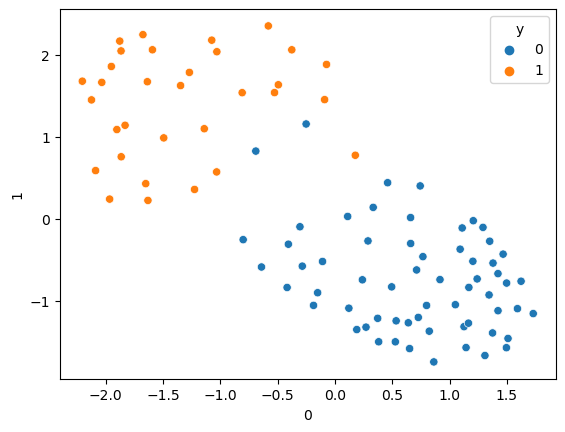

In [11]:
pm = proximity_matrix(rf, X_train, normalise=True)

df = pd.DataFrame(pm)
mds = MDS(n_components=2, random_state=CID, normalized_stress='auto', dissimilarity="precomputed")
df_mds = MDS().fit_transform(X=df)
df_mds = pd.DataFrame(df_mds)
df_mds['y'] = y_train.tolist()

sns.scatterplot(x=df_mds[0], y=df_mds[1], data=df_mds, hue='y')

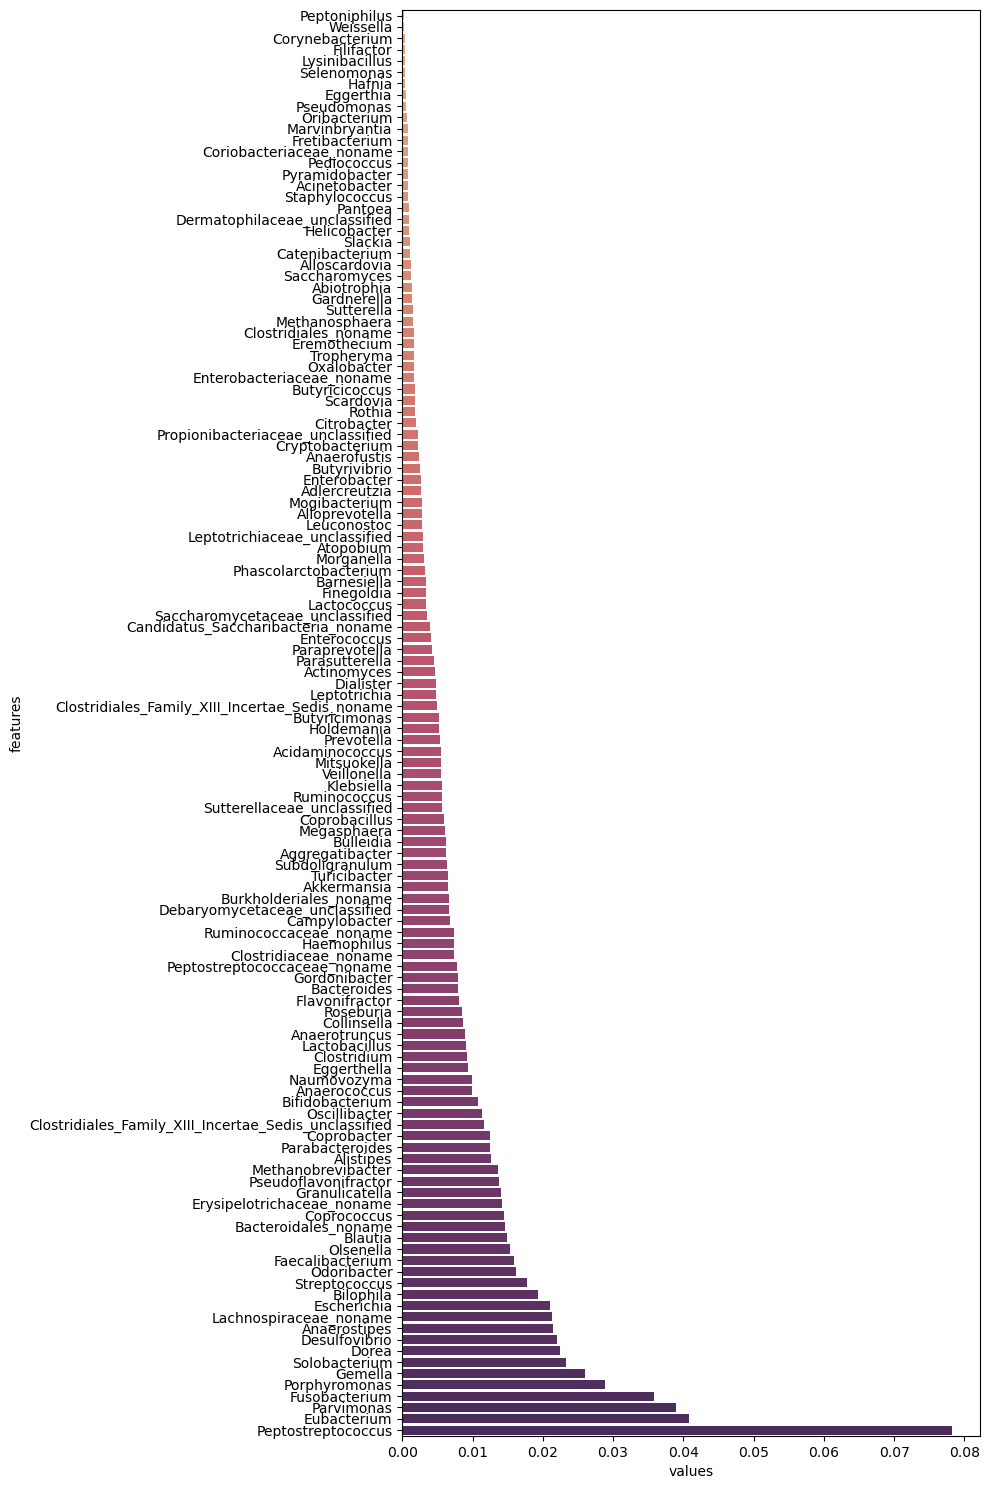

In [12]:
# look at feature importances 
feat_impo = rf.feature_importances_
features = cancer_microbiome_genus.columns[4:]

feature_dict = dict(zip(features, feat_impo))
bardf = pd.DataFrame(
        {'features': feature_dict.keys(),
         'values': feature_dict.values(),
        })
bardf = bardf.sort_values('values') # order values 
bardf = bardf[bardf['values'] != 0] # drop 0 value importance features

plt.figure(figsize=(10,15))

sns.barplot(x=bardf['values'], y=bardf['features'], data=bardf, palette = 'flare', order=bardf['features'], orient='h')

plt.tight_layout()

In [13]:
# we will use the same classifier for the permutation importance 
rf = RandomForestClassifier(
    n_estimators=100, 
    criterion='gini', 
    oob_score=True,
    random_state=CID
).fit(X_train, y_train)
%time feat_impo_perm = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=CID, scoring='accuracy')

# visualise the new importance values similarly to how we did it above

CPU times: total: 13.1 s
Wall time: 13.1 s


## Gradient Boosted Decision Trees

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage `n_classes_` regression trees are fit on the negative gradient of the loss function, e.g. binary or multiclass log loss. Binary classification is a special case where only a single regression tree is induced. To explore GBDTs we will use the [GradientBoostingClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) object and the sklearn-supported [XGBClassifier()](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) object from the [xgboost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html) package. To learn more about boosted trees take a look at the [XGBoost documentation](https://xgboost.readthedocs.io/en/stable/tutorials/model.html).

For the `xgboost.XGBClassifier()` object there are a number of parameters to similar to the Random Forest parameters we encountered before (n_estimators, max_depth, etc). You can set one of the various boosting algorithms to use with the parameter `tree_method` and you can learn more about the different options [here](https://xgboost.readthedocs.io/en/stable/treemethod.html).

In [14]:
# lets fit the model
clf = xgb.XGBClassifier(
    n_estimators=1000,
    tree_method="hist", 
    enable_categorical=False, 
    use_label_encoder=False, 
    predictor='cpu_predictor',
    random_state=CID
)
clf.fit(X_train, y_train)

C:\Users\jmp111\Anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor='cpu_predictor', random_state=0, ...)

### If you get an error below, think about what it tells you. We need to install something, how do we do this? (Make sure you restart the kernel if you leave the notebook open)

In [15]:
#conda install graphviz

In [16]:
# here you can visualise a tree and plot it (this can also be done for the sklearn functions too)
# Get a graph
graph = xgb.to_graphviz(clf, num_trees=1)

# Or get a matplotlib axis
ax = xgb.plot_tree(clf, num_trees=1)

ImportError: You must install graphviz to plot tree

In [ ]:
# now let's predict a model with out testing set, and also look at feature importances 
y_pred = clf.predict(X_test)
display(accuracy_score(y_test, y_pred))

# and let's explore some of the attributes, feel free to check more!
clf.feature_importances_

clf.get_booster

Now use the [sklearn.ensemble.GradientBoostingClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) function to look at different regularisation parameters and how they affect the model. Example code is given below to create graphs of the loss function deviance in relation to the number of boosting iterations. Make sure to read the different parameters required for the object, and change the combinations given below to try and find what maximises accuracy. Maybe try a different dataset as well...?

In [ ]:
constant_params = {
    "n_estimators": 500,
    "max_leaf_nodes": None,
    "max_depth": None,
    "random_state": 2,
    "min_samples_split": 5,
    "random_state": CID
} 

plt.figure()
for label, color, param_setting in [
    ("No shrinkage", "orange", {"learning_rate": 1.0, "subsample": 1.0}),
    ("learning_rate=0.2", "turquoise", {"learning_rate": 0.2, "subsample": 1.0}),
    ("subsample=0.5", "blue", {"learning_rate": 1.0, "subsample": 0.5}),
    ("learning_rate=0.2, subsample=0.5","gray",{"learning_rate": 0.2, "subsample": 0.5}),
    ("learning_rate=0.2, max_features=2", "magenta",{"learning_rate": 0.2, "max_features": 2})
]:
    params = dict(constant_params)
    params.update(param_setting)

    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # compute test set deviance
    test_deviance = np.zeros((params["n_estimators"],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)

    sns.lineplot(
        x=(np.arange(test_deviance.shape[0]) + 1)[::5],
        y=test_deviance[::5],
#         "-",
        color=color,
        label=label,
    )

plt.legend(loc="upper left")
plt.xlabel("Boosting Iterations")
plt.ylabel("Test Set Deviance")

plt.show()

How do the two gradient boosting algorithms ([GradientBoostingClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and [XGBClassifier()](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)) compare in terms of accuracy?

Do they find the same important features?

How does this change for other datasets?

# Your turn... Random Forest Regression!

Now that you have learned about random forests and decision trees in a classification setting, try to repeat some or all of the steps for regression models ([RandomForestRegressor()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), [GradientBoostingRegressor()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) and [XGBRegressor()](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor)).

Make sure to select the right metrics to evaluate (see BIDS 7).

Compare your results to those obtained with the regression methods from BIDS 7 ([Ridge()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), [Lasso()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), [ElasticNet()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) and [PLSRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html)) and BIDS 8 ([SVR()](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)).

In [ ]:
# Add your regression code here, which algorithm performs best?

